In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Synthetic ranking dataset
np.random.seed(42)
num_samples = 500
X = np.random.rand(num_samples, 10)  # 10 features
y = np.random.randint(0, 5, num_samples)  # Relevance scores (0 to 4)

# Group data for ranking (e.g., queries in search engines)
group = np.random.randint(1, 50, num_samples)

# Train-test split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    X, y, group, test_size=0.2, random_state=42
)


In [3]:
import numpy as np
import pandas as pd

# Generate a group structure where each group contains a random number of rows
num_samples = X_train.shape[0]
group_sizes = np.random.randint(5, 20, size=10)  # Random group sizes
group_sizes[-1] = num_samples - sum(group_sizes[:-1])  # Adjust the last group to match
group_train = list(group_sizes)


In [4]:
num_samples_test = X_test.shape[0]
group_sizes_test = np.random.randint(5, 20, size=5)
group_sizes_test[-1] = num_samples_test - sum(group_sizes_test[:-1])
group_test = list(group_sizes_test)


In [5]:
from xgboost import XGBRanker

xgb_ranker = XGBRanker(objective='rank:pairwise', random_state=42)
xgb_ranker.fit(X_train, y_train, group=group_train)
y_pred_xgb = xgb_ranker.predict(X_test)


In [7]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.3 MB/s eta 0:00:00


In [9]:
import numpy as np

# Create group IDs for training
num_groups = 10  # Number of groups
group_train = np.random.randint(0, num_groups, size=X_train.shape[0])  # Random group IDs


In [10]:
# Create group IDs for testing
group_test = np.random.randint(0, num_groups, size=X_test.shape[0])  # Random group IDs


In [15]:
# Create group IDs
num_samples = X_train.shape[0]
num_groups = 10  # Specify the number of groups
group_train = np.repeat(np.arange(num_groups), num_samples // num_groups)

# Adjust for any remaining rows
remaining_rows = num_samples % num_groups
if remaining_rows > 0:
    group_train = np.concatenate([group_train, np.repeat(num_groups - 1, remaining_rows)])

# Shuffle data within each group
shuffle_indices = np.argsort(group_train)
X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]
group_train = group_train[shuffle_indices]


In [16]:
from catboost import CatBoostRanker

cat_ranker = CatBoostRanker(
    iterations=500, learning_rate=0.1, verbose=0, random_seed=42
)
cat_ranker.fit(X_train, y_train, group_id=group_train)
y_pred_cat = cat_ranker.predict(X_test)


In [17]:
import pandas as pd

# Check group distribution
group_summary = pd.Series(group_train).value_counts()
print("Group distribution in training data:")
print(group_summary)


Group distribution in training data:
0    40
1    40
2    40
3    40
4    40
5    40
6    40
7    40
8    40
9    40
Name: count, dtype: int64


In [18]:
from catboost import CatBoostRanker

cat_ranker = CatBoostRanker(
    iterations=500, learning_rate=0.1, verbose=0, random_seed=42
)
cat_ranker.fit(X_train, y_train, group_id=group_train)
y_pred_cat = cat_ranker.predict(X_test)


In [22]:
import lightgbm as lgb

# Prepare group sizes for LightGBM
group_sizes = [sum(group_train == i) for i in np.unique(group_train)]

# Initialize the model
lgb_ranker = lgb.LGBMRanker(objective='lambdarank', random_state=42, learning_rate=0.1, n_estimators=500)



In [23]:
# Calculate the size of each group
group_sizes = [sum(group_train == i) for i in np.unique(group_train)]

# Validate group_sizes
assert sum(group_sizes) == X_train.shape[0], "Sum of group sizes does not match the number of rows in X_train."


In [24]:
print("Group Sizes for Training:", group_sizes)

Group Sizes for Training: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40]


In [31]:
# Training group sizes
num_samples_train = X_train.shape[0]
num_groups_train = 10  # Number of groups in training
train_group_sizes = [num_samples_train // num_groups_train] * num_groups_train

# Handle remaining rows in training
remaining_train_rows = num_samples_train % num_groups_train
if remaining_train_rows > 0:
    train_group_sizes[-1] += remaining_train_rows

# Testing group sizes
num_samples_test = X_test.shape[0]
num_groups_test = 5  # Number of groups in testing
test_group_sizes = [num_samples_test // num_groups_test] * num_groups_test

# Handle remaining rows in testing
remaining_test_rows = num_samples_test % num_groups_test
if remaining_test_rows > 0:
    test_group_sizes[-1] += remaining_test_rows

# Validate group sizes
assert sum(train_group_sizes) == num_samples_train, "Train group sizes do not match the number of rows in X_train!"
assert sum(test_group_sizes) == num_samples_test, "Test group sizes do not match the number of rows in X_test!"


In [32]:
lgb_ranker.fit(
    X_train,
    y_train,
    group=train_group_sizes,  # Correct training group sizes
    eval_set=[(X_test, y_test)],  # Validation set
    eval_group=[test_group_sizes],  # Correct test group sizes
    eval_metric='ndcg',  # Evaluation metric
    callbacks=[lgb.log_evaluation(10)]  # Log every 10 iterations
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

LGBMRanker(n_estimators=500, objective='lambdarank', random_state=42)

In [33]:
print("Training Group Sizes:", train_group_sizes)
print("Sum of Training Group Sizes:", sum(train_group_sizes))
print("Number of Training Samples:", num_samples_train)

print("Testing Group Sizes:", test_group_sizes)
print("Sum of Testing Group Sizes:", sum(test_group_sizes))
print("Number of Testing Samples:", num_samples_test)


Training Group Sizes: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Sum of Training Group Sizes: 400
Number of Training Samples: 400
Testing Group Sizes: [20, 20, 20, 20, 20]
Sum of Testing Group Sizes: 100
Number of Testing Samples: 100


In [35]:
def ndcg(y_true, y_pred, k=10):
    """Calculate NDCG@k."""
    order = np.argsort(-y_pred)
    y_true = np.take(y_true, order[:k])
    ideal = np.sort(y_true)[::-1][:k]
    dcg = np.sum((2**y_true - 1) / np.log2(np.arange(1, k + 1) + 1))
    idcg = np.sum((2**ideal - 1) / np.log2(np.arange(1, k + 1) + 1))
    return dcg / idcg if idcg > 0 else 0


In [36]:
def map_score(y_true, y_pred):
    """Calculate MAP."""
    order = np.argsort(-y_pred)
    y_true = np.take(y_true, order)
    precision_at_k = np.cumsum(y_true) / (np.arange(len(y_true)) + 1)
    return np.mean(precision_at_k)


In [37]:
# Generate predictions
y_pred_lgb = lgb_ranker.predict(X_test)

# Evaluate LightGBM Ranker
print("LightGBM NDCG:", ndcg(y_test, y_pred_lgb))
print("LightGBM MAP:", map_score(y_test, y_pred_lgb))


LightGBM NDCG: 0.5689269218826887
LightGBM MAP: 1.8611310771302547


In [38]:
# Collect results
results = {
    "Model": ["XGBoost", "CatBoost", "LightGBM"],
    "NDCG": [
        ndcg(y_test, y_pred_xgb),
        ndcg(y_test, y_pred_cat),
        ndcg(y_test, y_pred_lgb)
    ],
    "MAP": [
        map_score(y_test, y_pred_xgb),
        map_score(y_test, y_pred_cat),
        map_score(y_test, y_pred_lgb)
    ]
}

# Convert to DataFrame
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


      Model      NDCG       MAP
0   XGBoost  0.797114  1.810150
1  CatBoost  0.854076  1.803562
2  LightGBM  0.568927  1.861131


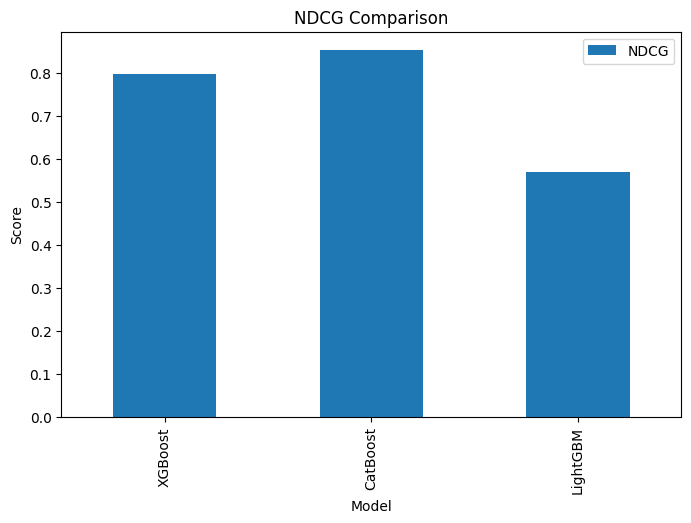

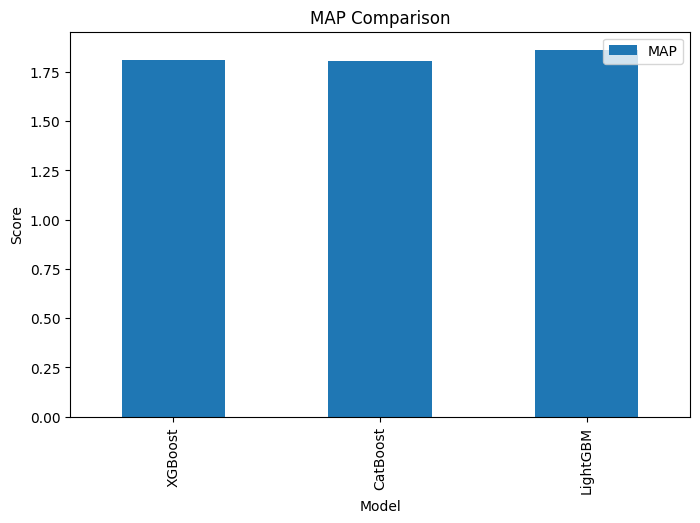

In [39]:
import matplotlib.pyplot as plt

# Plot NDCG Comparison
results_df.set_index("Model", inplace=True)
results_df[["NDCG"]].plot(kind="bar", figsize=(8, 5))
plt.title("NDCG Comparison")
plt.ylabel("Score")
plt.show()

# Plot MAP Comparison
results_df[["MAP"]].plot(kind="bar", figsize=(8, 5))
plt.title("MAP Comparison")
plt.ylabel("Score")
plt.show()
